## Import and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import optuna
from optuna.trial import Trial
from functools import partial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_metrics(metrics):
    df = pd.read_csv(metrics,parse_dates=['date'],index_col='date')
    df.dropna(inplace=True)
    return df

In [3]:
def toClassLabels(x, returnMetric):
    if x[returnMetric] > 0:
        return 1
    elif x[returnMetric] < 0:
        return -1
    else:
        return 0

In [4]:
def optunaOptimize(method = "accuracy"):
    # run optimization for hyperparams
    study = optuna.create_study(direction="maximize")
    study.optimize(partial(objective,
                           train_x=train_x, train_y=train_y,
                           train_rets=train_actRets, method=method), 
                   n_trials=200, n_jobs=-1)
    study.best_params
    
    print('Optimal Parameters\n', study.best_params)
    
    # create a random forest classifier with the optimal hyperparams and fit
    rf_clf = RandomForestClassifier(**study.best_params)
    rf_clf.fit(train_x, train_y)
    return rf_clf

def objective(trial:Trial, train_x=None, train_y=None, train_rets=None, method=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',600,2400,step=200)
    rf_max_depth = trial.suggest_int('max_depth',4,15)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train_x, train_y)
    

    if method == "profit":
        preds = rf_clf.predict(train_x)
        return (preds * train_rets).sum()
    
    elif method == "accuracy":
        return rf_clf.score(train_x, train_y)



In [5]:
def randomforest_feat_importances(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi):
    return fi.plot('cols', 'feat_imp', 'barh', figsize=(11,8), legend=False)

In [6]:
def profit_importance(m,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(100):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = m.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

def randomforest_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [7]:
def findBestPIComb(rf_clf, pi, bestFeats):
    profits = []
    feat=[]

    train_x_temp = train_x[bestFeats].copy()
    test_x_temp = test_x[bestFeats].copy()

    while len(train_x_temp.columns)>1:
        col_to_drop = pi.iloc[-1]['cols']  # remove worst prof importance one at a time
        train_x_temp.drop(col_to_drop, axis=1, inplace=True)
        test_x_temp.drop(col_to_drop, axis=1, inplace=True)

        rf_clf.fit(train_x_temp, train_y)
        pi = randomforest_profit_importance(rf_clf, test_x_temp, test_actRets)

        pred_test = rf_clf.predict(test_x_temp)

        print((pred_test * test_actRets).sum())
        profits.append((pred_test * test_actRets).sum())
        feat.append(train_x_temp.columns)
    
    return profits, feat

## Setup

In [8]:
# read in raw data
dataPath = "final_features/HYG_metrics.csv"
raw = get_metrics(dataPath)

# add a column based on 'fwd_rtn_5min'
# 1 if the return is pos
# 0 if the return is 0
# -1 if the return is neg
raw['rel_perf'] = raw.apply(lambda x: toClassLabels(x, 'fwd_rtn_5min'), axis=1)

In [9]:
train = raw.loc[:'2020-06']  # train on first half of year
test = raw.loc['2020-07':]  # test on second half of year

In [10]:
colsToDrop = ['rel_perf', 'iNAV','PRICE','NBB','NBO','NBOqty', 'NBBqty', 'NBO_temp', 'NBB_temp'] + [col for col in raw.columns if 'rtn' in col]

train_x = train.drop(colsToDrop, axis=1)
train_y = train['rel_perf']
train_actRets = train['fwd_rtn_5min']

test_x = test.drop(colsToDrop, axis=1)
test_y = test['rel_perf']
test_actRets = test['fwd_rtn_5min']

## Random Forest Based on Maximizing Accuracy

In [11]:
rf_clf_accuracy = optunaOptimize('accuracy')

# the test/valid accuarcy
print("Train Accuracy:", rf_clf_accuracy.score(train_x, train_y))
print("Test Accuracy:", rf_clf_accuracy.score(test_x, test_y))

Optimal Parameters
 {'n_estimators': 40, 'max_features': 'log2', 'min_samples_leaf': 600, 'max_depth': 11}
Train Accuracy: 0.536403880568899
Test Accuracy: 0.46510122954608485


num feats:  21


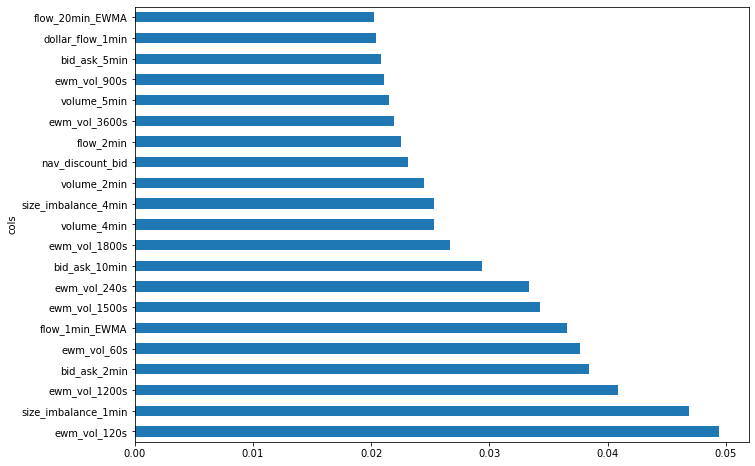

In [12]:
# best features have highest profit importance
fi = randomforest_feat_importances(rf_clf_accuracy, train_x)
features = fi[(fi['feat_imp'] > 0.02)]
print('num feats: ', features.shape[0])
plot_fi(features);

In [13]:
# now using only the most important features as seen above
bestFeats_acc = features['cols'].values

rf_clf_accuracy.fit(train_x[bestFeats_acc], train_y)

# the test/valid accuarcy
print("Train Accuracy:", rf_clf_accuracy.score(train_x[bestFeats_acc], train_y))
print("Valid Accuracy:", rf_clf_accuracy.score(test_x[bestFeats_acc], test_y))

Train Accuracy: 0.5321653951210323
Valid Accuracy: 0.4652861236941851


In [14]:
# profit importances
# best features have lowest profit importance
pi = randomforest_profit_importance(rf_clf_accuracy,
                                    test_x[bestFeats_acc],
                                    test_actRets)

pi

,cols,pi_imp
12,volume_2min,0.039931
15,ewm_vol_3600s,0.068220
6,ewm_vol_1500s,0.076780
17,ewm_vol_900s,0.077574
4,ewm_vol_60s,0.077592
16,volume_5min,0.079612
0,ewm_vol_120s,0.080047
20,flow_20min_EWMA,0.084609
14,flow_2min,0.085358
1,size_imbalance_1min,0.089892


In [15]:
# try diff combinations of features from the best features we found above
profits, feats = findBestPIComb(rf_clf_accuracy, pi, bestFeats_acc)

0.14690247572827408
0.11857743776841227
0.22137867629015534
0.21012002329456508
0.14550255455674072
0.18087126861182987
0.10951330711936486
0.1404743421741469
0.0986936949766379
0.19951622275297
0.22399396079501452
0.21707455586009555
0.19533219905549407
0.16137090279959537
0.15470771836398342
0.1452239739946914
0.14554602119475607
0.06737706306737595
0.09382992222692564
0.03289965697838346


In [16]:
n = np.argmax(profits)  # index of best feature combination
print(feats[n])
print(len(feats[n]))

Index(['ewm_vol_1200s', 'bid_ask_2min', 'ewm_vol_60s', 'flow_1min_EWMA',
       'ewm_vol_1500s', 'ewm_vol_1800s', 'size_imbalance_4min',
       'nav_discount_bid', 'ewm_vol_3600s', 'volume_5min'],
      dtype='object')
10


Train Accuracy: 0.5222755957426768
Test Accuracy: 0.46315984099103263


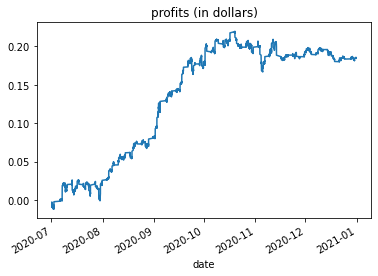

In [17]:
# final model evaluation use these best params
bestFeats_accuracy = list(feats[n])
rf_clf_accuracy.fit(train_x[bestFeats_accuracy], train_y)

# the train/test accuarcy
print("Train Accuracy:", rf_clf_accuracy.score(train_x[bestFeats_accuracy], train_y))
print("Test Accuracy:", rf_clf_accuracy.score(test_x[bestFeats_accuracy], test_y))

cumProfits_accuracy = (rf_clf_accuracy.predict(test_x[bestFeats_accuracy]) * test_actRets).cumsum()
cumProfits_accuracy.plot();
plt.title("profits (in dollars)");

These results assume we go long 1 dollar of HYG when a positive return is predicted and short 1 dollar of HYG when a neagtive return is predicted.

## Random Forest Based on Maximizing Profit

In [18]:
rf_clf_profit = optunaOptimize('profit')

# the test/valid accuarcy
print("Train Accuracy:", rf_clf_profit.score(train_x, train_y))
print("Valid Accuracy:", rf_clf_profit.score(test_x, test_y))

Optimal Parameters
 {'n_estimators': 25, 'max_features': 'log2', 'min_samples_leaf': 600, 'max_depth': 9}
Train Accuracy: 0.5347084863897523
Valid Accuracy: 0.4703707127669409


num feats:  18


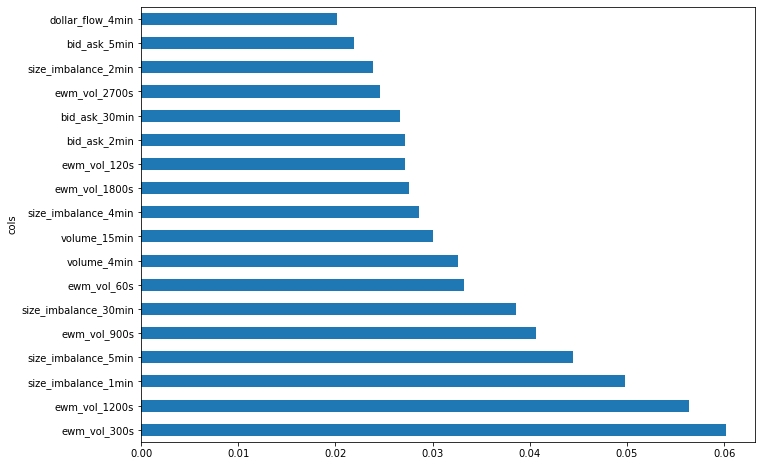

In [19]:
fi = randomforest_feat_importances(rf_clf_profit, train_x)
features = fi[(fi['feat_imp'] > 0.02)]
print('num feats: ', features.shape[0])
plot_fi(features);

In [20]:
# now using only the most important features as seen above
bestFeats_profit = features['cols'].values

rf_clf_profit.fit(train_x[bestFeats_profit], train_y)

# the test/valid accuarcy
print("Train Accuracy:", rf_clf_profit.score(train_x[bestFeats_profit], train_y))
print("Valid Accuracy:", rf_clf_profit.score(test_x[bestFeats_profit], test_y))

Train Accuracy: 0.5228407271357257
Valid Accuracy: 0.4758250901358972


In [21]:
# profit importances
# best features have lowest profit importance
pi = randomforest_profit_importance(rf_clf_profit,
                                    test_x[bestFeats_profit],
                                    test_actRets)

pi

,cols,pi_imp
17,dollar_flow_4min,0.129920
2,size_imbalance_1min,0.159922
8,volume_15min,0.161840
1,ewm_vol_1200s,0.165383
6,ewm_vol_60s,0.171643
3,size_imbalance_5min,0.176814
5,size_imbalance_30min,0.176849
11,ewm_vol_120s,0.177677
10,ewm_vol_1800s,0.190322
15,size_imbalance_2min,0.191371


In [22]:
# try diff combinations of features from the best features we found above
profits, feats = findBestPIComb(rf_clf_profit, pi, bestFeats_profit)

0.22751886781479247
0.09950248380709961
0.1366613031128715
0.16422444005617676
0.11739090912255853
0.20048817507275726
-0.029666411099358123
0.16843629099649
0.2016583255162296
0.1970730199643978
0.2423486524425308
0.12879442088497006
0.31252009201824954
0.17954263265476988
0.26205169841323805
0.25747553333737916
0.03774545764934239


In [23]:
n = np.argmax(profits)  # index of best feature combination
print(feats[n])
print(len(feats[n]))

Index(['ewm_vol_1200s', 'size_imbalance_1min', 'ewm_vol_60s', 'ewm_vol_120s',
       'dollar_flow_4min'],
      dtype='object')
5


Train Accuracy: 0.5098427050956014
Test Accuracy: 0.4769344550244985


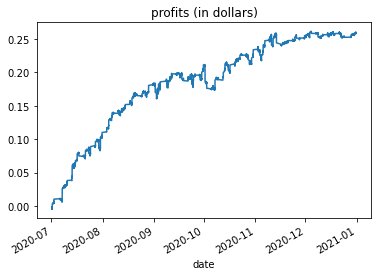

In [24]:
# final model evaluation use these best params
bestFeats_profit = list(feats[n])
rf_clf_profit.fit(train_x[bestFeats_profit], train_y)

# the train/test accuarcy
print("Train Accuracy:", rf_clf_profit.score(train_x[bestFeats_profit], train_y))
print("Test Accuracy:", rf_clf_profit.score(test_x[bestFeats_profit], test_y))

cumProfits_profit = (rf_clf_profit.predict(test_x[bestFeats_profit]) * test_actRets).cumsum()
cumProfits_profit.plot();
plt.title("profits (in dollars)");

These results assume we go long 1 dollar of HYG when a positive return is predicted and short 1 dollar of HYG when a neagtive return is predicted.

## Results Summary

The final results suggest maximizing profit is better than maximizing prediction accuracy. The optimal features suggested by random forest classifer maxmizing profit are: 
 - ewm_vol_1200s
 - size_imbalance_1min
 - ewm_vol_60s
 - ewm_vol_120s
 - dollar_flow_4min

# Visualize Trees

In [16]:
import graphviz  # run to install package: conda install python-graphviz
from sklearn import tree
from IPython.display import Image

In [13]:
# the best tree we found
rf_clf = RandomForestClassifier(**{'n_estimators': 25, 'max_features': 'log2', 'min_samples_leaf': 600, 'max_depth': 9})
rf_clf.fit(train_x[['ewm_vol_1200s', 'size_imbalance_1min', 'ewm_vol_60s', 'ewm_vol_120s','dollar_flow_4min']],
           train_y)

RandomForestClassifier(max_depth=9, max_features='log2', min_samples_leaf=600,
                       n_estimators=25)

In [24]:
for i in range(25):
    T = rf_clf.estimators_[i]
    #visualizing some trees
    dot_data = tree.export_graphviz(T,
                                    feature_names = ['ewm_vol_1200s', 'size_imbalance_1min', 'ewm_vol_60s', 'ewm_vol_120s','dollar_flow_4min'],
                                    class_names = ['neg_ret (-1)', 'zero_ret (0)', 'pos_ret (1)'])
    graph = graphviz.Source(dot_data)
    graph.render(f'tree_pdfs/tree{i}')